In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer

In [4]:
df = pd.read_csv("./data/news_postprocess.csv", delimiter=";")
df.head()

,Sentence,Sentiment,sentiment_encoded
0,"In 2009 , Comptel slipped to a net loss of EUR...",negative,0
1,Repeats sees 2008 EBITA above 18 pct of sales .,positive,2
2,$AAPL price momentum weakening going into the ...,negative,0
3,Why $MCD looks set to fall further. http://stk...,negative,0
4,Net cash flow from operating activities was a ...,neutral,1


In [5]:
encoder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = encoder.encode(df["Sentence"].to_list(), show_progress_bar=True)
labels = df["sentiment_encoded"].values

Batches: 100%|██████████| 81/81 [00:08<00:00,  9.52it/s]


In [6]:
# creating a train test validation split
from sklearn.model_selection import train_test_split

# First split: Train+Val and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Check the shapes
print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (1651, 384)
Val shape: (413, 384)
Test shape: (516, 384)


In [7]:
# making the neural net
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


optimizer = Adam(learning_rate=0.0001)
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/abaziz/Documents/programming/portfolio-projects/stock-mood/backend/model/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,243 (227.51 KB)

 Trainable params: 57,987 (226.51 KB)

 Non-trainable params: 256 (1.00 KB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3375 - loss: 1.9064 - val_accuracy: 0.4358 - val_loss: 1.3656
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3980 - loss: 1.7248 - val_accuracy: 0.5182 - val_loss: 1.3575
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3988 - loss: 1.6926 - val_accuracy: 0.5569 - val_loss: 1.3476
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4453 - loss: 1.5894 - val_accuracy: 0.5714 - val_loss: 1.3344
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4348 - loss: 1.5667 - val_accuracy: 0.5908 - val_loss: 1.3186
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4378 - loss: 1.5201 - val_accuracy: 0.6053 - val_loss: 1.2970
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4675 - loss: 1.4352 - val_accuracy: 0.6223 - val_loss: 1.2713
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4834 - loss: 1.4362 - val_accuracy: 0.6368 - v

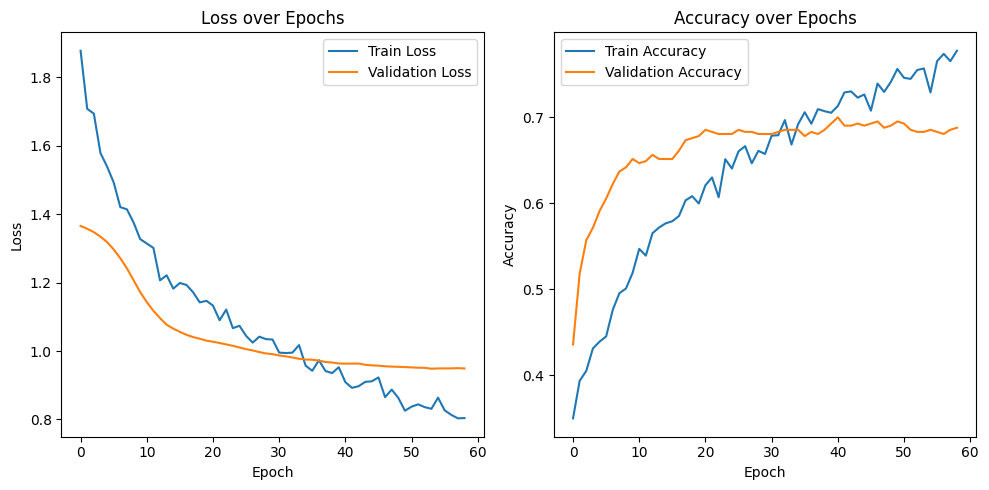

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7189922480620154
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.75      0.73       172
     neutral       0.69      0.69      0.69       172
    positive       0.75      0.72      0.73       172

    accuracy                           0.72       516
   macro avg       0.72      0.72      0.72       516
weighted avg       0.72      0.72      0.72       516



In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[99 12 26]
 [23 93 22]
 [15 33 90]]
